In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [2]:
# pickle_file = 'data/COX_DATA_FULL_LIVING.pkl'
pickle_file = '../data/COX_DATA_FULL_LIVING_EXPERIMENTAL.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)

dataset.drop(['DIAG_KI', 'COD_KI'], axis=1, inplace=True)

In [3]:
yes_categorical=[
                "PRE_TX_TXFUS", 
                "GENDER",
                "ON_DIALYSIS", 
                "ETHCAT", 
                "ETHCAT_DON",
                'DIAB',
                'HCV_SEROSTATUS',  
                'LIV_DON_TY',
                # "ABO_MAT", 
                'HBV_CORE', 
                
            ]
yes_numerical = [   
                # "SERUM_CREAT", # might be data leakage, as it is after the transplant
                "AGE", 
                "AGE_DON",
                "DIALYSIS_TIME",                
                # "KI_CREAT_PREOP", # negative importance
                # "NPKID", # negative importance
                # "HGT_CM_CALC",  # negative importance
                # "BMI_DON_CALC", # negative importance
                ]

In [4]:
numeric_features = [x for x in yes_numerical if x != "PTIME" and x != "PSTATUS"]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) # maybe it's better to use not ignore
])

# Combine transformations for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, yes_numerical),
        ('cat', categorical_transformer, yes_categorical)
    ]
)

# Set up the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
# X = pipeline.fit_transform(dataset[yes_categorical + yes_numerical])

# For calculating feature importance
categorical_x = encode_categorical(dataset[yes_categorical])
numerical_x = standardize(dataset[yes_numerical])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [6]:
rsf = RandomSurvivalForest(n_estimators=3, n_jobs=-1, random_state=42, low_memory=True)
rsf.fit(X_train[1000:], y_train[1000:])

RandomSurvivalForest(low_memory=True, n_estimators=3, n_jobs=-1,
                     random_state=42)

In [7]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

# evaluate_model(rsf, X_test, y_test, y_train, times)
evaluate_model_uno_c(rsf, X_test[500:], y_test[500:], y_train[1000:], times)

(0.6962975414459149, 12143231, 5260977, 2990, 3547)

- 0.6765997616352277, 11806774, 5596229, 4195, 3547 -- all coxnet features
- (0.6863628389858669, 11975477, 5422948, 8773, 3547)
- (0.6926788145550595, 12066401, 5338051, 2746, 3547) -- minus 4 features
- (0.6976510749974301, 12242994, 5160898, 3306, 3547) -- minus npkid
- (0.7005440984901211, 12156021, 5248164, 3013, 3547) -- minus SERUM_CREAT

In [8]:
from sklearn.inspection import permutation_importance

# uncoment if you want to calculate permutation importance (data must not be processed by pipeline)
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)

In [9]:
pd.set_option('display.max_rows', None)

# columns = numeric_features + categorical_features

importances_df = pd.DataFrame(result.importances_mean, index=X_train.columns)
importances_df.columns = ['Importance']
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print out feature importances
print(importances_df)

                   Importance
AGE                  0.089483
DIAB=3.0             0.018387
ON_DIALYSIS=Y        0.013666
DIAB=5.0             0.011546
DIAB=2.0             0.010067
DIALYSIS_TIME        0.007122
ETHCAT=4             0.003815
PRE_TX_TXFUS=Y       0.003697
AGE_DON              0.003434
LIV_DON_TY=2.0       0.003378
ETHCAT=2             0.002879
ETHCAT_DON=2.0       0.002851
ETHCAT_DON=4.0       0.001751
ETHCAT=5             0.001425
HCV_SEROSTATUS=P     0.001154
LIV_DON_TY=9.0       0.000956
GENDER=M             0.000787
LIV_DON_TY=4.0       0.000680
HBV_CORE=P           0.000561
LIV_DON_TY=8.0       0.000476
HBV_CORE=ND          0.000323
ETHCAT_DON=5.0       0.000304
LIV_DON_TY=10.0      0.000297
LIV_DON_TY=6.0       0.000198
ETHCAT=6             0.000110
ETHCAT_DON=7.0       0.000103
ETHCAT=9             0.000064
DIAB=998.0           0.000037
ETHCAT_DON=6.0       0.000030
ETHCAT=7             0.000018
LIV_DON_TY=12.0      0.000000
LIV_DON_TY=3.0      -0.000029
ETHCAT_DON

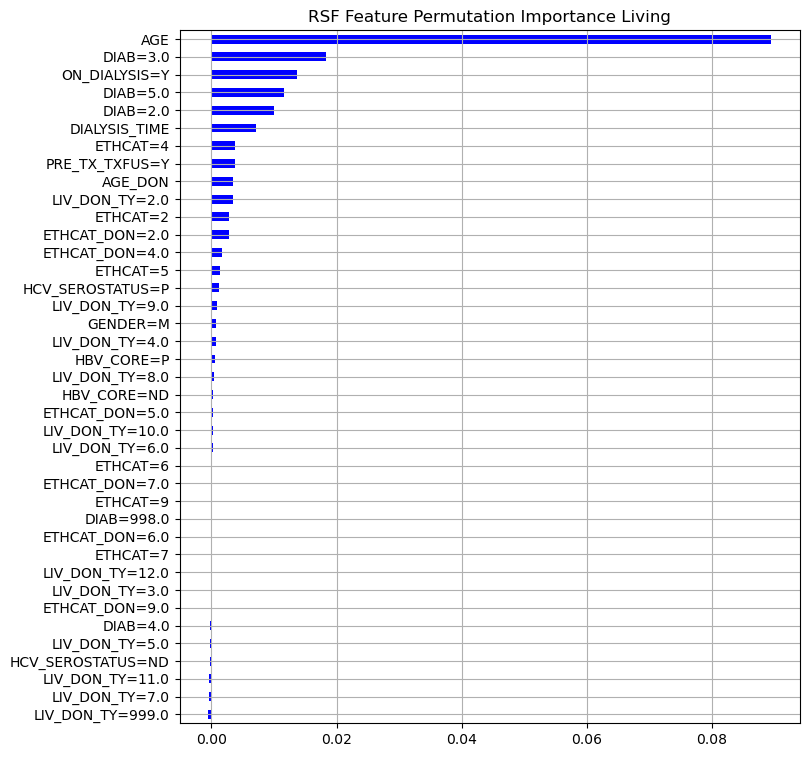

In [12]:
import matplotlib.pyplot as plt
plt_importances =importances_df.sort_values(by='Importance', ascending=True)
plt_importances.plot.barh(color='blue', legend=False, title='RSF Feature Permutation Importance Living', grid=True, figsize=(8, 9))
path = "../../Thesis/Images/Results/"
plt.savefig(path + "RSF_FI_living.pdf", bbox_inches="tight")